In [1]:
import torch
import numpy as np
from functools import partial

In [2]:
import sys
#sys.path.append('./NVIDIA_physicsnemo_examples-weather_corrdiff_DB/datasets')
sys.path.append('/leap/DB_scratch/physicsnemo/research/corrdiff_27_Nov')

In [3]:
from datasets.nyc import NYCDataset

In [107]:
dataset = NYCDataset(
    data_path='/leap/NYC_data_128/4_dec/',
    stats_path='',
    preload=True,
    sel_time=[0, 100]  # Just 10 samples for demo
)

Using NC files


Preloading data into memory...
Loaded input: (13, 100, 128, 128), output: (5, 100, 128, 128)


In [42]:
dataset.input.coords

Coordinates:
  * variable             (variable) object 104B '2m_temperature' ... 'geopote...
  * time                 (time) datetime64[ns] 80B 2020-01-01 ... 2020-01-01T...
    atmosphere           float64 8B 0.0
    gribfile_projection  float64 8B nan
    step                 timedelta64[ns] 8B 00:00:00
    valid_time           (time) datetime64[ns] 80B 2020-01-01 ... 2020-01-01T...
    latitude             (y, x) float64 131kB 39.53 39.53 39.52 ... 41.98 41.97
    longitude            (y, x) float64 131kB 283.6 283.6 283.6 ... 289.0 289.1
    surface              float64 8B 0.0
    valid_time_tp        (time) datetime64[ns] 80B 2020-01-01T01:00:00 ... 20...

In [39]:
y,x = dataset[0]

In [40]:
y.shape

(5, 128, 128)

In [41]:
x.shape

(13, 128, 128)

In [5]:
print(f"Dataset size: {len(dataset)}")
print(f"Image shape: {dataset.image_shape()}")
print(f"Input channels: {len(dataset.input_channels())}")
print(f"Output channels: {len(dataset.output_channels())}")


Dataset size: 10
Image shape: (128, 128)
Input channels: 13
Output channels: 5


In [6]:
# ==============================================================================
# STEP 2: Get a single sample
# ==============================================================================
image_tar, image_lr = dataset[3]
image_tar_t = torch.from_numpy(image_tar)
image_lr_t = torch.from_numpy(image_lr)
print(f"\nSample shapes:")
print(f"  Target (HR): {image_tar_t.shape}")
print(f"  Input (LR): {image_lr_t.shape}")


Sample shapes:
  Target (HR): torch.Size([5, 128, 128])
  Input (LR): torch.Size([13, 128, 128])


In [18]:
out_channels = dataset.output_channels()

In [23]:
out_channels

[ChannelMetadata(name='refc', level='', auxiliary=False),
 ChannelMetadata(name='t2m', level='', auxiliary=False),
 ChannelMetadata(name='u10', level='', auxiliary=False),
 ChannelMetadata(name='v10', level='', auxiliary=False),
 ChannelMetadata(name='tp', level='', auxiliary=False)]

In [8]:
dataset.input_channels()

[ChannelMetadata(name='2m_temperature', level='', auxiliary=False),
 ChannelMetadata(name='temperature_500', level='', auxiliary=False),
 ChannelMetadata(name='temperature_850', level='', auxiliary=False),
 ChannelMetadata(name='total_column_water_vapour', level='', auxiliary=False),
 ChannelMetadata(name='total_precipitation', level='', auxiliary=False),
 ChannelMetadata(name='10m_u_component_of_wind', level='', auxiliary=False),
 ChannelMetadata(name='u_component_of_wind_500', level='', auxiliary=False),
 ChannelMetadata(name='u_component_of_wind_850', level='', auxiliary=False),
 ChannelMetadata(name='10m_v_component_of_wind', level='', auxiliary=False),
 ChannelMetadata(name='v_component_of_wind_500', level='', auxiliary=False),
 ChannelMetadata(name='v_component_of_wind_850', level='', auxiliary=False),
 ChannelMetadata(name='geopotential_500', level='', auxiliary=False),
 ChannelMetadata(name='geopotential_850', level='', auxiliary=False)]

In [26]:
# ...existing code...
in_channels = dataset.input_channels()
match_channels = [3, 0, 5, 8, 4]

# Select the channel objects
selected_channels = [in_channels[i] for i in match_channels]

# (Optional) just their names
selected_channel_names = [in_channels[i].name for i in match_channels]
# ...existing code...

In [27]:
selected_channel_names

['total_column_water_vapour',
 '2m_temperature',
 '10m_u_component_of_wind',
 '10m_v_component_of_wind',
 'total_precipitation']

In [9]:
# ==============================================================================
# STEP 3: Load Models
# ==============================================================================
from physicsnemo import Module

# Load regression model (deterministic baseline)
net_reg = Module.from_checkpoint("/leap/DB_scratch/physicsnemo/research/corrdiff_27_Nov/results_nyc_3/checkpoints/checkpoints_regression/UNet.0.10000384.mdlus")
net_reg = net_reg.eval().cuda().to(memory_format=torch.channels_last)

# Load diffusion residual model (stochastic refinement)
net_res = Module.from_checkpoint('/leap/DB_scratch/physicsnemo/research/corrdiff_27_Nov/results_nyc_3/checkpoints/checkpoints_diffusion/EDMPrecondSuperResolution.0.10000384.mdlus')
net_res = net_res.eval().cuda().to(memory_format=torch.channels_last)


In [10]:
# ==============================================================================
# STEP 4: Regression Step (Deterministic Prediction)
# ==============================================================================
from physicsnemo.utils.corrdiff import regression_step

img_lr_batch = image_lr_t.unsqueeze(0).cuda()  # Add batch dim
print(f"\nInput for regression: {img_lr_batch.shape}")



Input for regression: torch.Size([1, 13, 128, 128])


/usr/local/lib/python3.12/dist-packages/physicsnemo/utils/corrdiff/utils.py:26: ExperimentalFeatureWarning: You are importing from 'physicsnemo.experimental'. The APIs in this namespace are experimental, under active development, and may change without notice. Expect possible back-compatibility breaking changes and only partial test coverage.
  from physicsnemo.experimental import ExperimentalFeatureWarning


In [11]:
num_channels = len(dataset.output_channels())

image_reg = regression_step(
    net=net_reg,
    img_lr=img_lr_batch,
    latents_shape=(1, num_channels, 128, 128),
    lead_time_label=None
)
print(f"Regression output: {image_reg.shape}")


Regression output: torch.Size([1, 5, 128, 128])


In [12]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Regression pred')

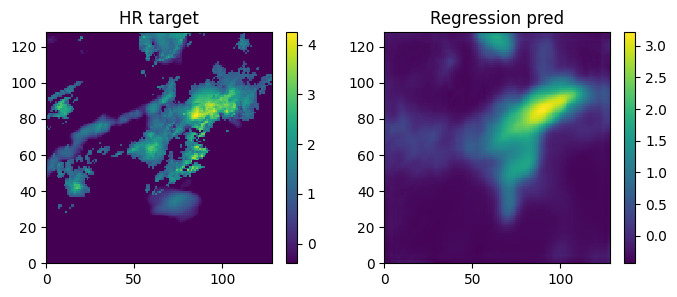

In [13]:
plt.figure(figsize=(8,3))

plt.subplot(121)
plt.pcolormesh(image_tar[0,:,:])
plt.colorbar()
plt.title("HR target")


plt.subplot(122)
plt.pcolormesh(image_reg[0,0,:,:].cpu().numpy())
plt.colorbar()
plt.title('Regression pred')

Text(0.5, 1.0, 'LR input')

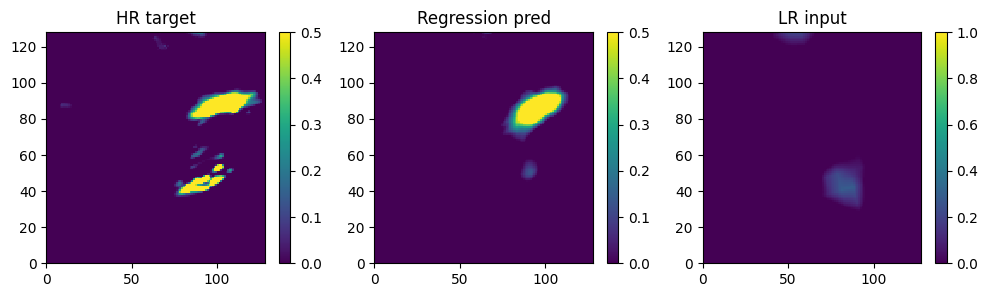

In [14]:
plt.figure(figsize=(12,3))

var = -1
plt.subplot(131)
plt.pcolormesh(image_tar[var,:,:], vmin=0, vmax=0.5)
plt.colorbar()
plt.title("HR target")


plt.subplot(132)
plt.pcolormesh(image_reg[0,var,:,:].cpu().numpy(), vmin=0, vmax=0.5)
plt.colorbar()
plt.title('Regression pred')

plt.subplot(133)
plt.pcolormesh(image_lr[4,:,:], vmin=0, vmax=1)
plt.colorbar()
plt.title('LR input')

Text(0.5, 1.0, 'Regression pred')

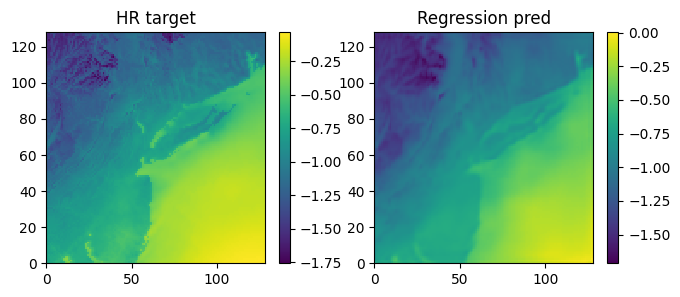

In [15]:
plt.figure(figsize=(12,3))

var = 1
plt.subplot(131)
plt.pcolormesh(image_tar[var,:,:])
plt.colorbar()
plt.title("HR target")


plt.subplot(132)
plt.pcolormesh(image_reg[0,var,:,:].cpu().numpy())
plt.colorbar()
plt.title('Regression pred')


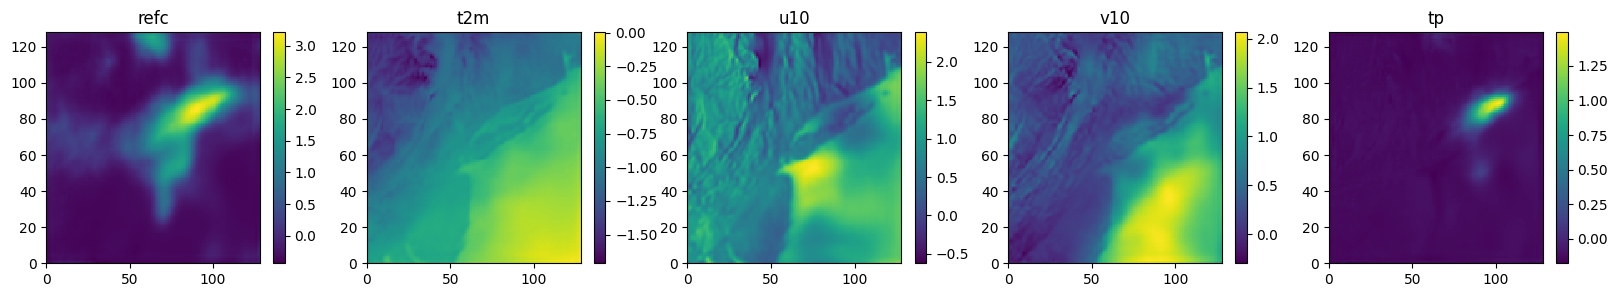

In [20]:
plt.figure(figsize=(20,3))

for i in range(5):
    plt.subplot(151+i)
    plt.pcolormesh(image_reg[0,i ,:,:].cpu().numpy())
    plt.colorbar()
    plt.title(out_channels[i].name)


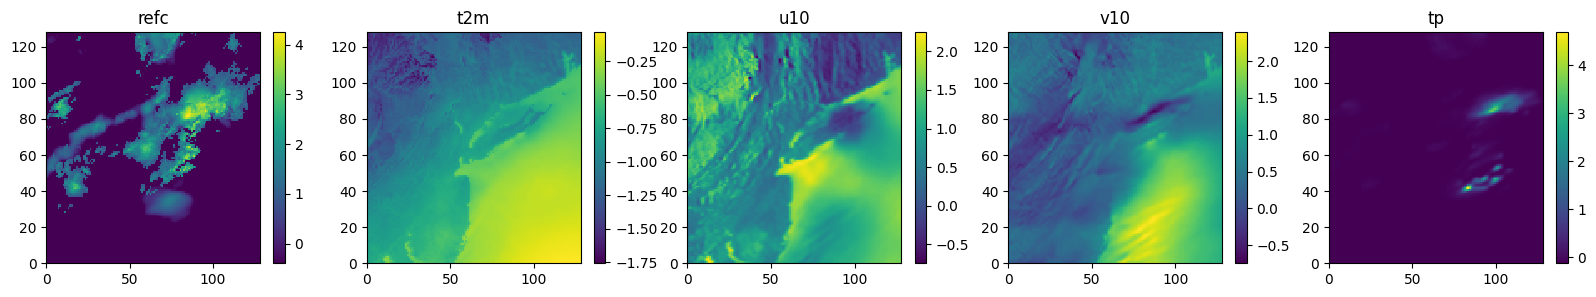

In [22]:
plt.figure(figsize=(20,3))

for i in range(5):
    plt.subplot(151+i)
    plt.pcolormesh(image_tar[i ,:,:])
    plt.colorbar()
    plt.title(out_channels[i].name)


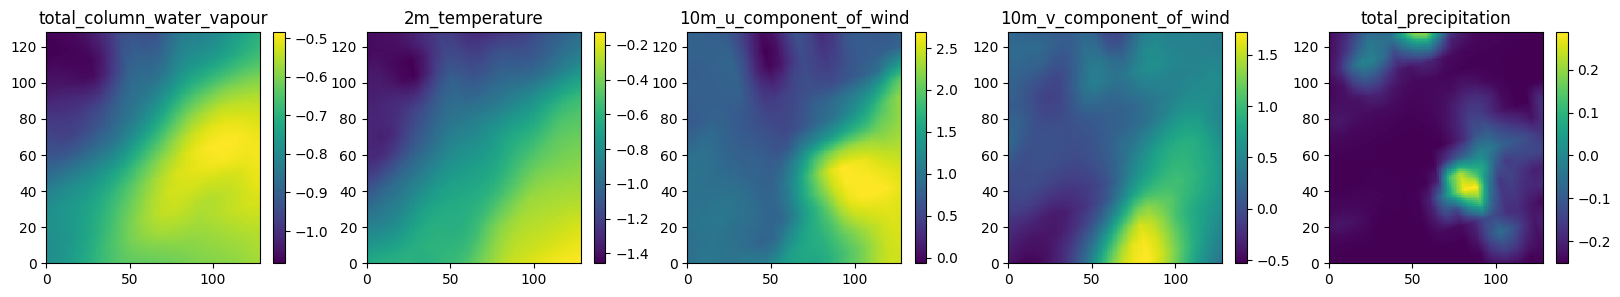

In [29]:
plt.figure(figsize=(20,3))

for idx, i in enumerate(match_channels):
    plt.subplot(151+idx)
    plt.pcolormesh(image_lr[i ,:,:])
    plt.colorbar()
    plt.title(selected_channel_names[idx])


In [30]:
# ==============================================================================
# STEP 5: Diffusion Step (Stochastic Refinement)
# ==============================================================================
from physicsnemo.utils.corrdiff import diffusion_step
from physicsnemo.utils.diffusion import deterministic_sampler, stochastic_sampler

# Match generate.py exactly
# from omegaconf import OmegaConf
# cfg = OmegaConf.load('/leap/DB_scratch/physicsnemo/research/corrdiff_27_Nov/conf/config_generate_nyc_2.yaml')

# sampler_fn = partial(
#     deterministic_sampler,
#     num_steps=cfg.sampler.num_steps,
#     solver=cfg.sampler.solver,
#     patching=None
# )


In [31]:

# un comment below for simple deterministic sampler
# Create sampler function
# sampler_fn = partial(
#     deterministic_sampler,
#     num_steps=35,
#     solver='heun',
#     patching=None
# )
sampler_fn = partial(stochastic_sampler, patching=None)


# Generate ensemble of 4 members
num_ensembles = 4
seeds = list(range(num_ensembles))

image_res = diffusion_step(
    net=net_res,
    sampler_fn=sampler_fn,
    img_shape=(128, 128),
    img_out_channels=len(dataset.output_channels()),
    rank_batches=[seeds],  # All seeds in one batch
    img_lr=img_lr_batch.expand(num_ensembles, -1, -1, -1),
    rank=0,
    device='cuda',
    mean_hr=image_reg[0:1],  # Use regression as mean
    lead_time_label=None
)
print(f"\nDiffusion output (ensemble): {image_res.shape}")


  0%|                                                                                                                                                      | 0/1 [00:00<?, ?batch/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/batch]


Diffusion output (ensemble): torch.Size([4, 5, 128, 128])


In [32]:
# ==============================================================================
# STEP 6: Combine Predictions
# ==============================================================================
# Option 1: Regression only
output_regression = image_reg

# Option 2: Diffusion only
output_diffusion = image_res

# Option 3: Combined (regression + diffusion residual)
output_combined = image_reg + image_res

print(f"\nFinal outputs:")
print(f"  Regression: {output_regression.shape}")
print(f"  Diffusion: {output_diffusion.shape}")
print(f"  Combined: {output_combined.shape}")


Final outputs:
  Regression: torch.Size([1, 5, 128, 128])
  Diffusion: torch.Size([4, 5, 128, 128])
  Combined: torch.Size([4, 5, 128, 128])


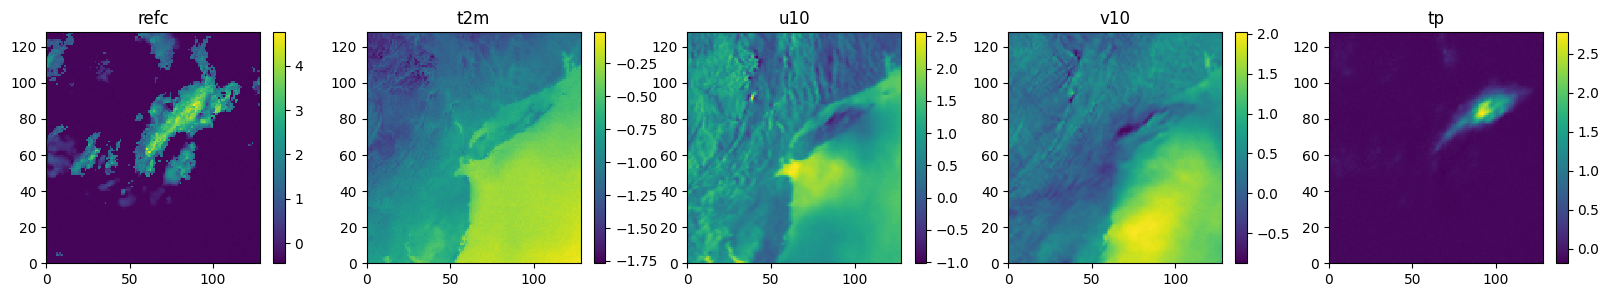

In [33]:
plt.figure(figsize=(20,3))

for i in range(5):
    plt.subplot(151+i)
    plt.pcolormesh(output_combined[0,i ,:,:].cpu().numpy())
    plt.colorbar()
    plt.title(out_channels[i].name)


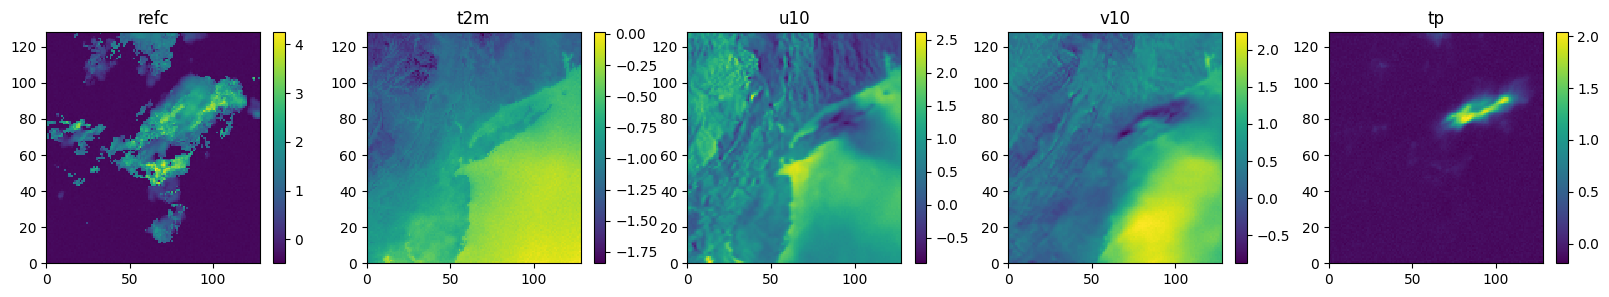

In [34]:
plt.figure(figsize=(20,3))

for i in range(5):
    plt.subplot(151+i)
    plt.pcolormesh(output_combined[-1,i ,:,:].cpu().numpy())
    plt.colorbar()
    plt.title(out_channels[i].name)


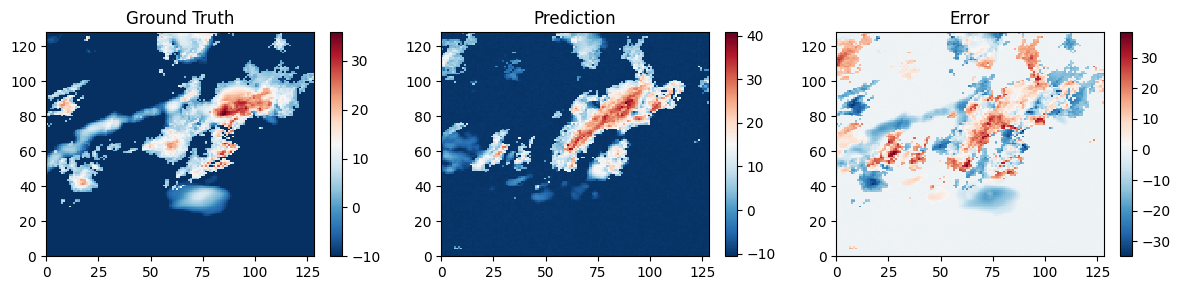

In [35]:
# ==============================================================================
# STEP 7: Denormalize and Visualize
# ==============================================================================
import matplotlib.pyplot as plt

# Denormalize (convert back to physical units)
input_phys = dataset.denormalize_input(image_lr_t.cpu().numpy())
output_phys = dataset.denormalize_output(output_combined[0].cpu().numpy())
target_phys = dataset.denormalize_output(image_tar_t.cpu().numpy())

# Plot first channel (e.g., temperature)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].pcolormesh(target_phys[0], cmap='RdBu_r')
fig.colorbar(axes[0].collections[0], ax=axes[0])
axes[0].set_title('Ground Truth')

axes[1].pcolormesh(output_phys[0], cmap='RdBu_r')
fig.colorbar(axes[1].collections[0], ax=axes[1])
axes[1].set_title('Prediction')

axes[2].pcolormesh(output_phys[0] - target_phys[0], cmap='RdBu_r')
fig.colorbar(axes[2].collections[0], ax=axes[2])
axes[2].set_title('Error')

plt.tight_layout()
plt.show()

In [36]:
input_phys.shape

(13, 128, 128)

In [37]:
output_phys.shape

(5, 128, 128)

In [136]:
from physicsnemo.utils.corrdiff import regression_step
from physicsnemo.utils.corrdiff import diffusion_step
from physicsnemo.utils.diffusion import deterministic_sampler, stochastic_sampler
import xarray as xr

def full_generate_func(dataset,  net_reg, net_res, len_to_gen=None, num_ensembles=4): 
    # Your generation code here
    if len_to_gen is  None:
        len_to_gen = len(dataset)
    
    
    num_in_channels = len(dataset.input_channels())
    num_out_channels = len(dataset.output_channels())
    img_shape = dataset.image_shape()

    input_phys_all = np.zeros((len_to_gen, num_in_channels) + img_shape)
    output_phys_all = np.zeros((len_to_gen, num_ensembles, num_out_channels) + img_shape)
    target_phys_all = np.zeros((len_to_gen, num_out_channels) + img_shape)

    for idx in range(len_to_gen):
        print('Generating sample {}/{}...'.format(idx+1, len_to_gen))
        image_tar, image_lr = dataset[idx]
        image_tar_t = torch.from_numpy(image_tar)
        image_lr_t = torch.from_numpy(image_lr)

        img_lr_batch = image_lr_t.unsqueeze(0).cuda()  # Add batch dim

        num_channels = len(dataset.output_channels())

        image_reg = regression_step(
            net=net_reg,
            img_lr=img_lr_batch,
            latents_shape=(1, num_channels, 128, 128),
            lead_time_label=None
        )
        print("Shape of regression image "+str(image_reg.shape))
        
        sampler_fn = partial(stochastic_sampler, patching=None)

        image_res = diffusion_step(
            net=net_res,
            sampler_fn=sampler_fn,
            img_shape=(128, 128),
            img_out_channels=len(dataset.output_channels()),
            rank_batches=[seeds],  # All seeds in one batch
            img_lr=img_lr_batch.expand(num_ensembles, -1, -1, -1),
            rank=0,
            device='cuda',
            mean_hr=image_reg[0:1],  # Use regression as mean
            lead_time_label=None
        )

        output_regression = image_reg
        output_diffusion = image_res
        output_combined = image_reg + image_res


        input_phys_all[idx,:,:,:] = dataset.denormalize_input(image_lr_t.cpu().numpy())
        output_phys_all[idx,:,:,:,:] = dataset.denormalize_output(output_combined.cpu().numpy())
        target_phys_all[idx,:,:,:] = dataset.denormalize_output(image_tar_t.cpu().numpy())



    ds_input_phys = xr.DataArray(input_phys_all, dims=['time', 'variable','y','x'], 
                        coords=dataset.input.isel(time=slice(0, len_to_gen)).coords).to_dataset(dim='variable')
    ds_output_phys = xr.DataArray(output_phys_all, dims=['time', 'ensemble','variable','y','x'],
                                  coords=dataset.output.isel(time=slice(0, len_to_gen)).coords).to_dataset(dim='variable')
    ds_target_phys = xr.DataArray(target_phys_all, dims=['time', 'variable','y','x'],
                                 coords=dataset.output.isel(time=slice(0, len_to_gen)).coords).to_dataset(dim='variable')

    return ds_input_phys, ds_output_phys, ds_target_phys

In [137]:
ds_in, ds_out, ds_tar = full_generate_func(dataset, net_reg, net_res, len_to_gen=10, num_ensembles=3)

Generating sample 1/10...
Shape of regression image torch.Size([1, 5, 128, 128])


  0%|                                                                                                                                       | 0/1 [00:00<?, ?batch/s]


ValueError: Expected first dimension of size 4, got 3

In [110]:
ds_in['total_precipitation'] = ds_in['total_precipitation']*1000 # convert from m to kg/m^2

In [111]:
common_channels = ['total_column_water_vapour', '2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind', 'total_precipitation']

In [112]:
def plot_comparison(ds_in, ds_tar, ds_out, common_channels, time_idx=0, ensembles=[0, 1, 2], 
                    vmin_dict=None, vmax_dict=None, cmap_dict=None, figsize=(20, 15)):
    """
    Plot comparison of input, target, and prediction datasets.
    
    Parameters:
    -----------
    ds_in : xr.Dataset
        Input dataset (ERA5)
    ds_tar : xr.Dataset
        Target dataset (HRRR)
    ds_out : xr.Dataset
        Output/prediction dataset
    common_channels : list
        List of variable names from ds_in that correspond to ds_tar/ds_out variables in order
    time_idx : int
        Time index to plot
    ensembles : list
        List of ensemble indices to plot
    vmin_dict : dict
        Dictionary mapping variable names to vmin values (using ds_tar variable names)
    vmax_dict : dict
        Dictionary mapping variable names to vmax values (using ds_tar variable names)
    cmap_dict : dict
        Dictionary mapping variable names to colormap names (using ds_tar variable names)
    figsize : tuple
        Figure size
    """
    if vmin_dict is None:
        vmin_dict = {}
    if vmax_dict is None:
        vmax_dict = {}
    if cmap_dict is None:
        cmap_dict = {}
    
    target_vars = list(ds_tar.data_vars)
    n_rows = 2 + len(ensembles)  # ERA5 + HRRR + ensemble rows
    n_cols = len(target_vars)
    
    plt.figure(figsize=figsize)
    
    # Plot ERA5 inputs (using common_channels mapping)
    for i, (in_var, tar_var) in enumerate(zip(common_channels, target_vars)):
        plt.subplot(n_rows, n_cols, 1 + i)
        vmin = vmin_dict.get(in_var, None)
        vmax = vmax_dict.get(in_var, None)
        cmap = cmap_dict.get(in_var, 'viridis')
        plt.pcolormesh(ds_in[in_var].isel(time=time_idx), vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar()
        plt.title(f'{in_var}\n(ERA5)')
    
    # Plot HRRR targets
    for i, var in enumerate(target_vars):
        plt.subplot(n_rows, n_cols, n_cols + 1 + i)
        vmin = vmin_dict.get(var, None)
        vmax = vmax_dict.get(var, None)
        cmap = cmap_dict.get(var, 'viridis')
        plt.pcolormesh(ds_tar[var].isel(time=time_idx), vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar()
        plt.title(f'{var}\n(HRRR)')
    
    # Plot ensemble predictions
    for ens_idx, ens in enumerate(ensembles):
        for i, var in enumerate(target_vars):
            plt.subplot(n_rows, n_cols, (2 + ens_idx) * n_cols + 1 + i)
            vmin = vmin_dict.get(var, None)
            vmax = vmax_dict.get(var, None)
            cmap = cmap_dict.get(var, 'viridis')
            plt.pcolormesh(ds_out[var].isel(time=time_idx, ensemble=ens), 
                          vmin=vmin, vmax=vmax, cmap=cmap)
            plt.colorbar()
            plt.title(f'{var}\n(Pred ens={ens})')
    
    plt.tight_layout()
    #return plt.gcf()

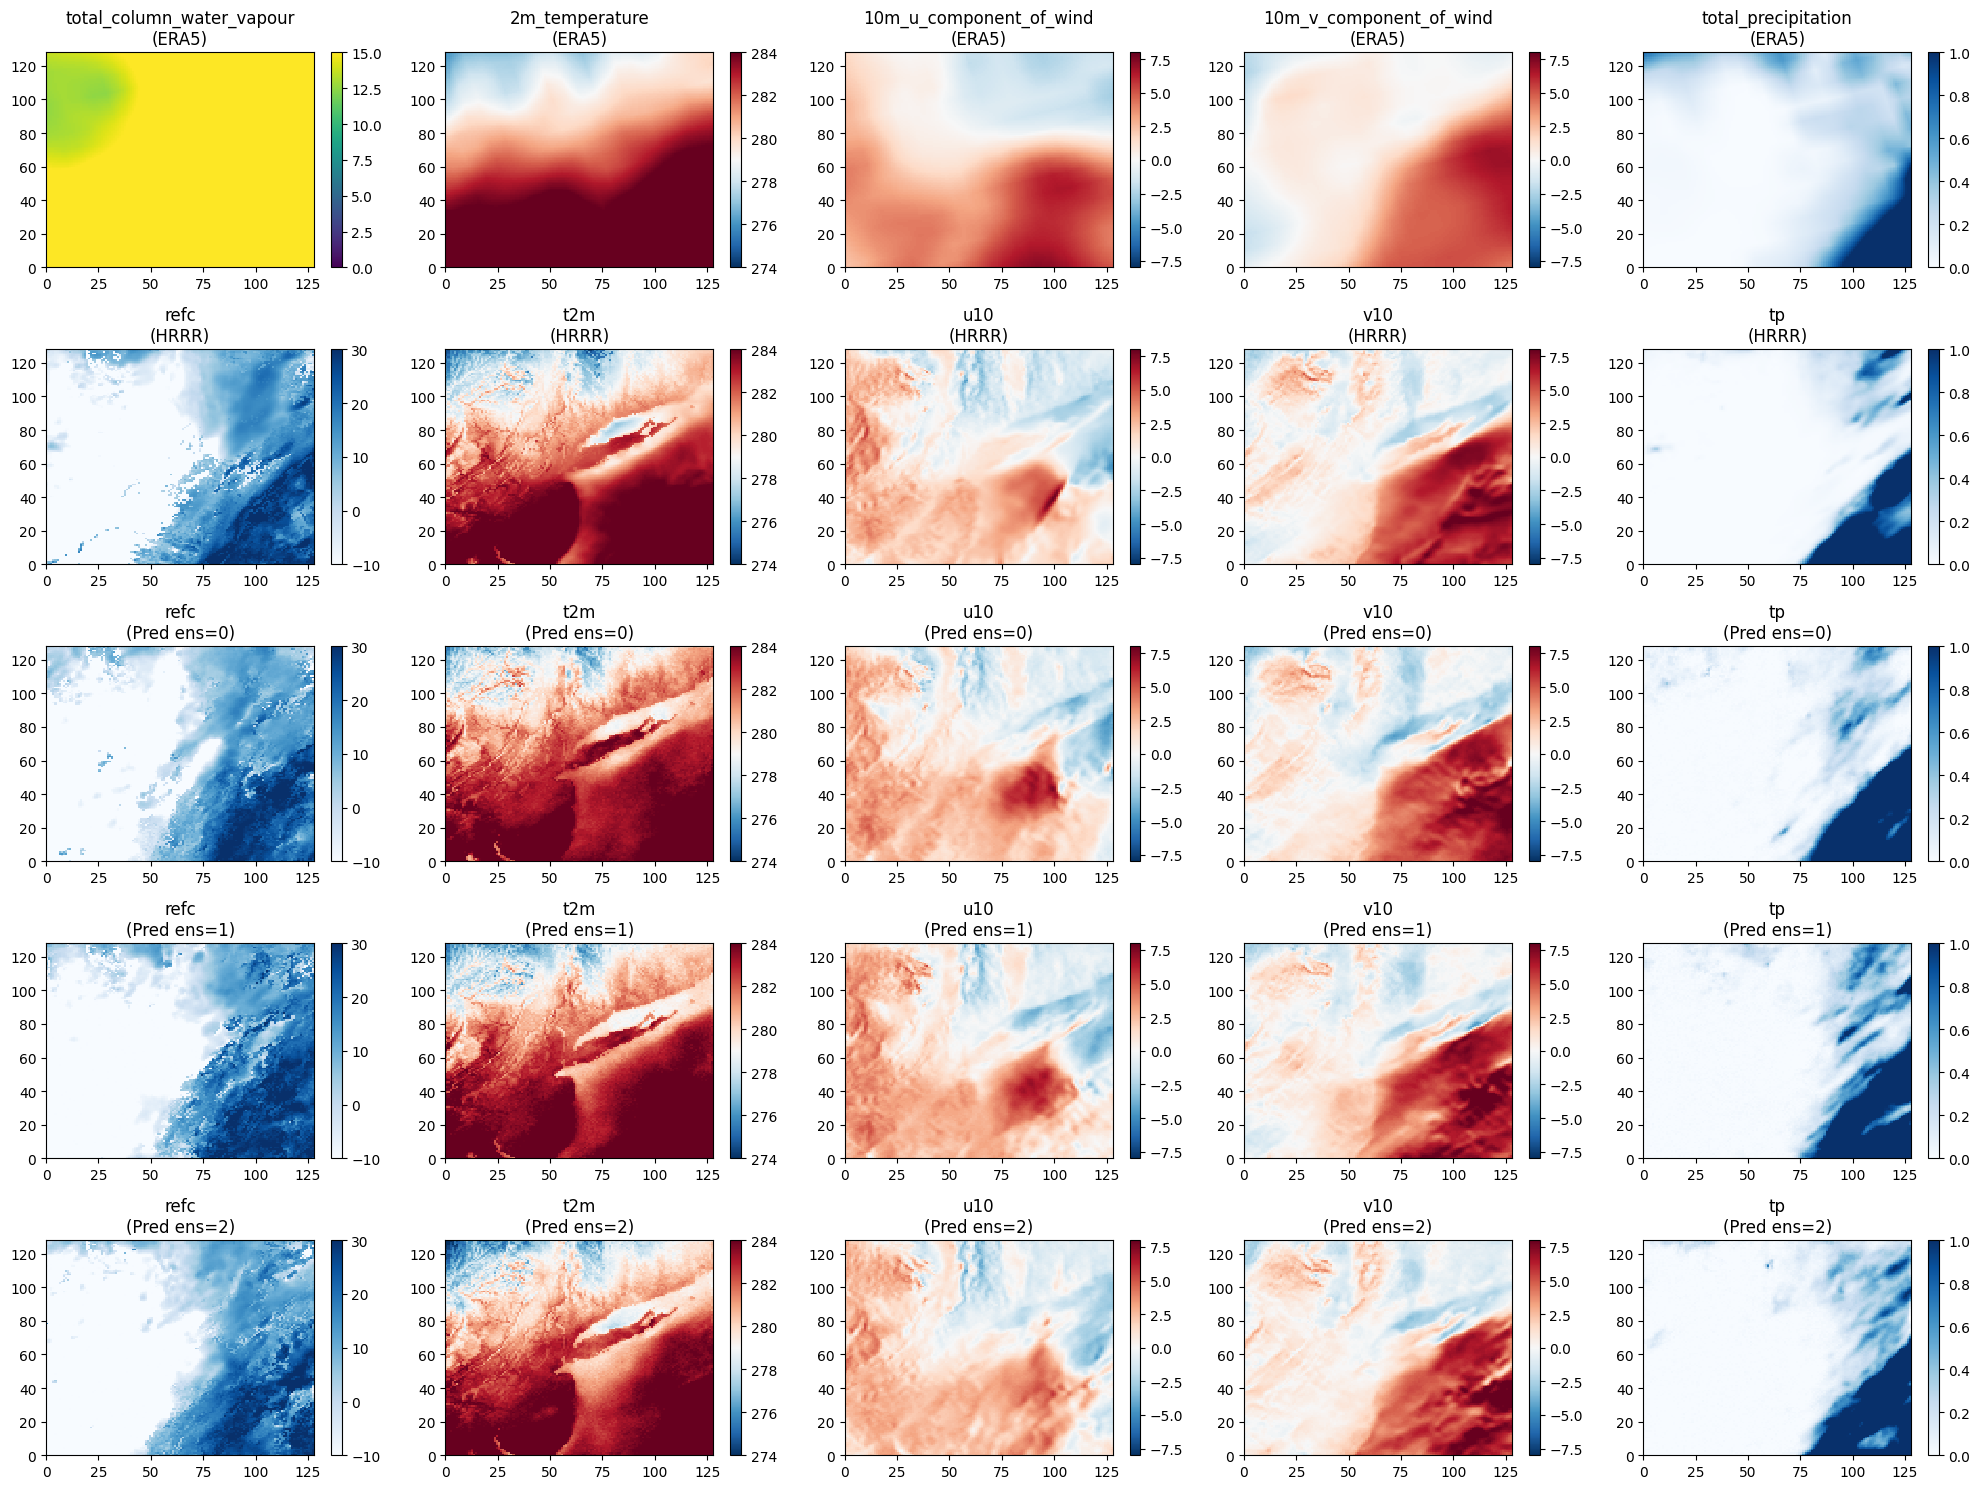

In [113]:
vmin_dict = {
    'total_precipitation': 0,
    'tp': 0,
    '2m_temperature': 274,
    't2m': 274,
    '10m_u_component_of_wind': -8,
    'u10': -8,
    '10m_v_component_of_wind': -8,
    'v10': -8,
    'total_column_water_vapour': 0,
    'refc': -10,

}

vmax_dict = {
    'total_precipitation': 1,
    'tp': 1,
    '2m_temperature': 284,
    't2m': 284,
    '10m_u_component_of_wind': 8,
    'u10': 8,
    '10m_v_component_of_wind': 8,
    'v10': 8,
    'total_column_water_vapour': 15,
    'refc': 30,
}

cmap_dict = {
    'total_precipitation': 'Blues',
    '2m_temperature': 'RdBu_r',
    't2m': 'RdBu_r',
    '10m_u_component_of_wind': 'RdBu_r',
    'u10': 'RdBu_r',
    '10m_v_component_of_wind': 'RdBu_r',
    'v10': 'RdBu_r',
    'total_column_water_vapour': 'viridis',
    'refc': 'Blues',
    'tp': 'Blues'
}

plot_comparison(ds_in, ds_tar, ds_out, common_channels, time_idx=90, ensembles=[0, 1, 2],
                vmin_dict=vmin_dict, vmax_dict=vmax_dict, cmap_dict=cmap_dict)

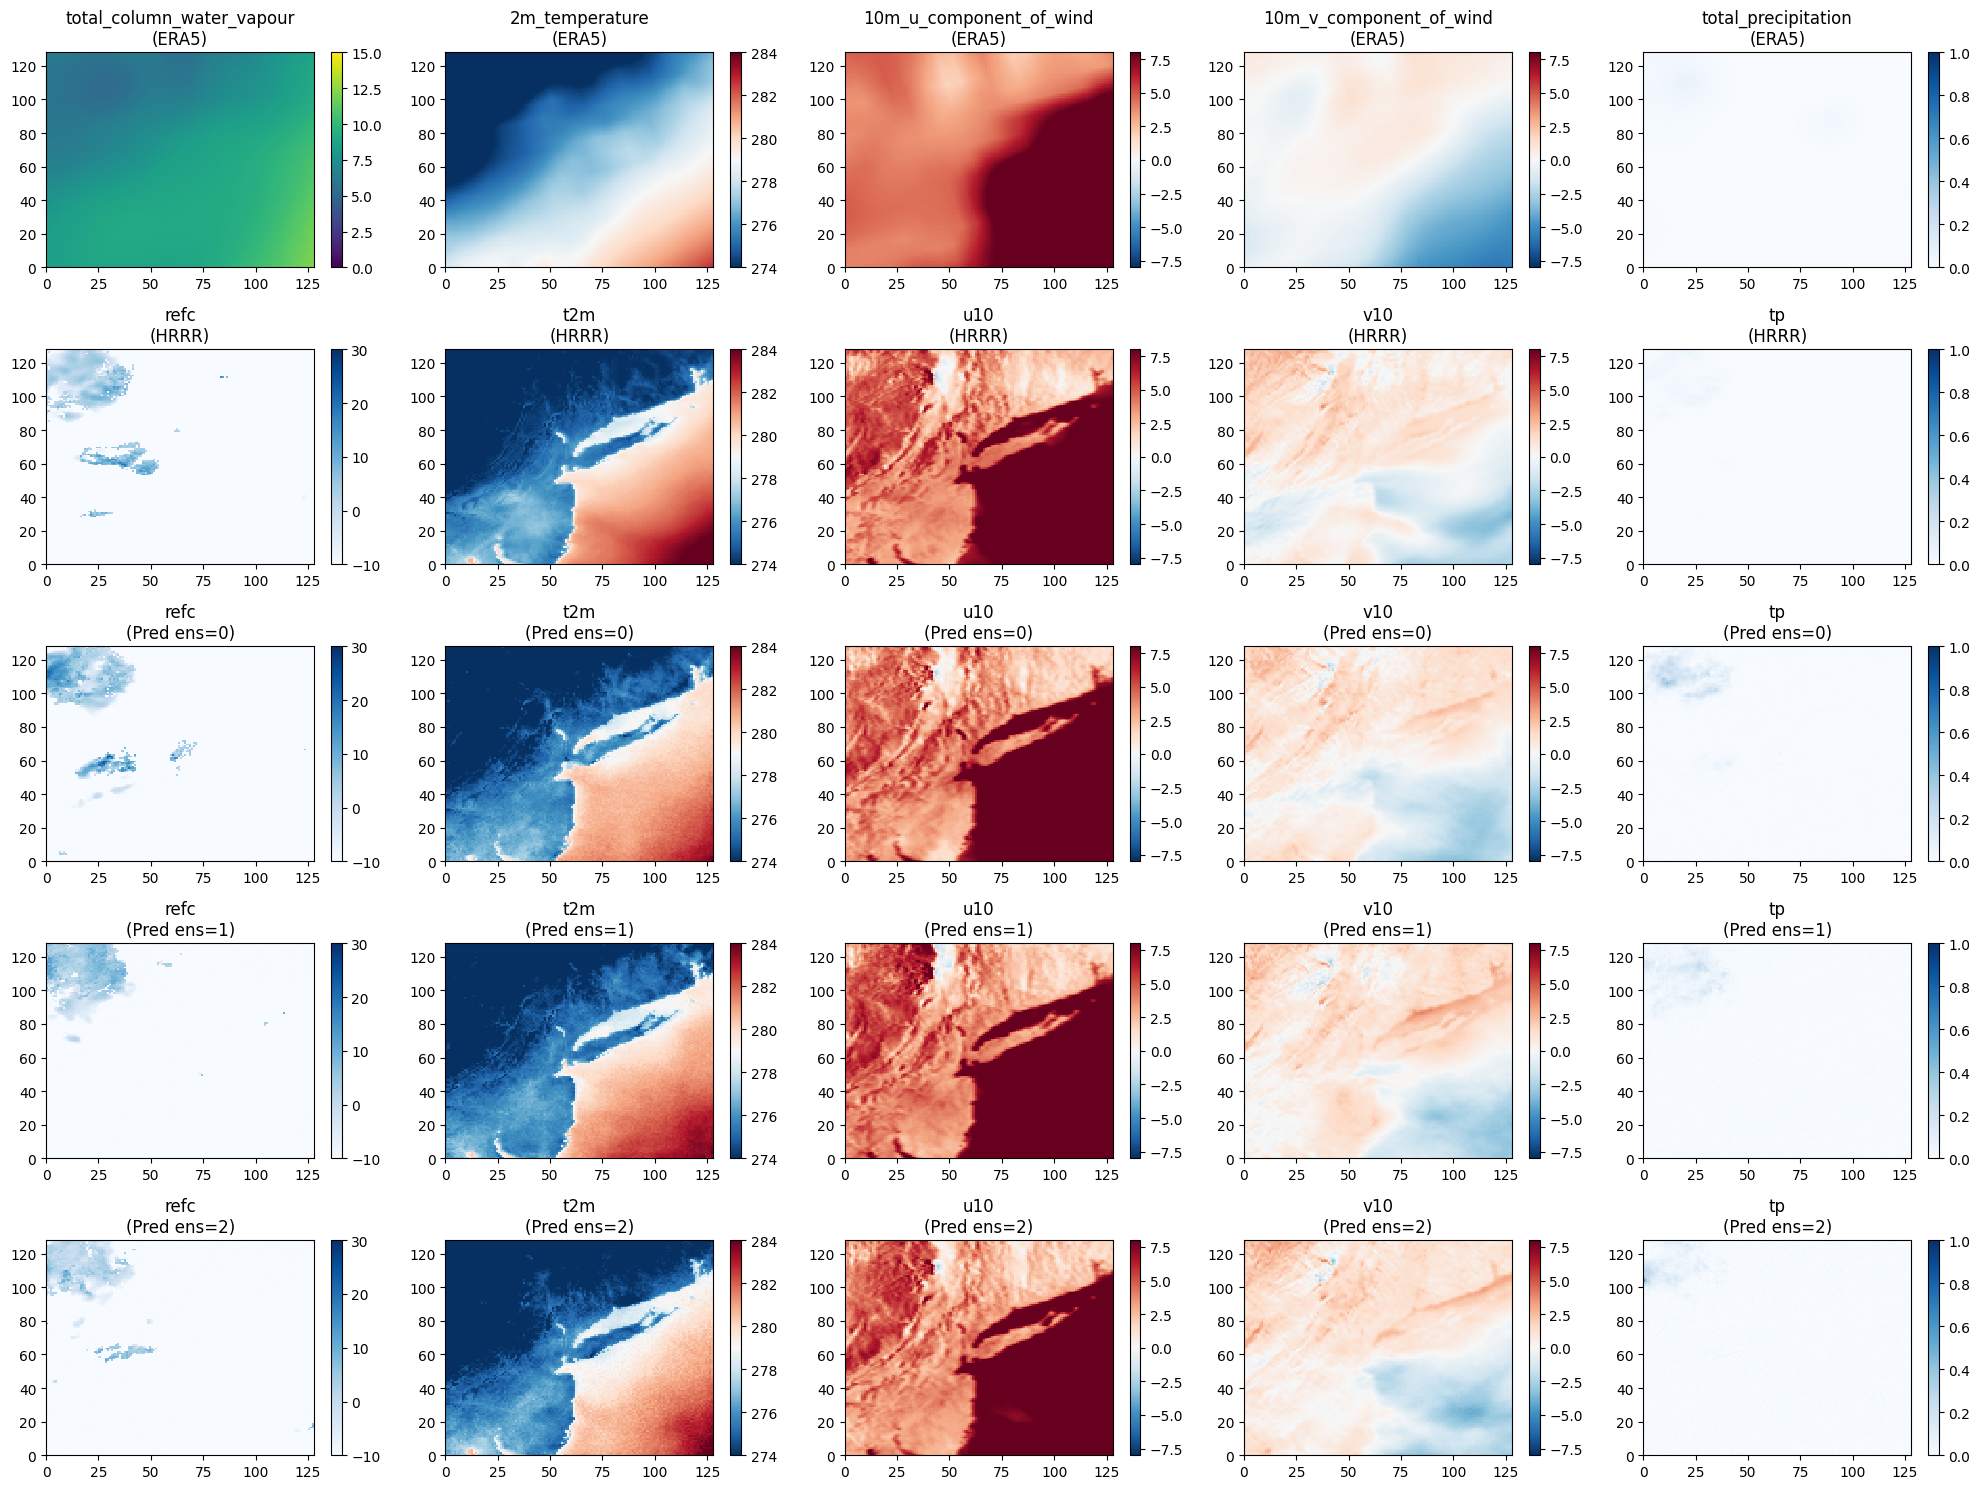

In [103]:
plot_comparison(ds_in, ds_tar, ds_out, common_channels, time_idx=8, ensembles=[0, 1, 2],
                vmin_dict=vmin_dict, vmax_dict=vmax_dict, cmap_dict=cmap_dict)

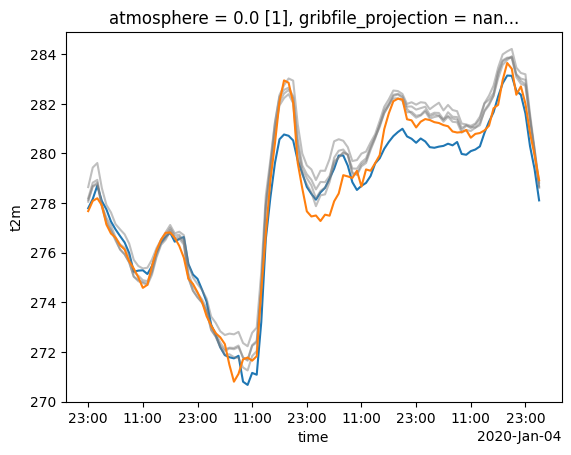

In [ ]:
ds_in['2m_temperature'].isel(x=50, y=60).plot()
for i in range(4):
    ds_out['t2m'].isel(ensemble=i, x=50, y=60).plot(color='gray', alpha=0.5)
ds_tar['t2m'].isel(x=50, y=60).plot()

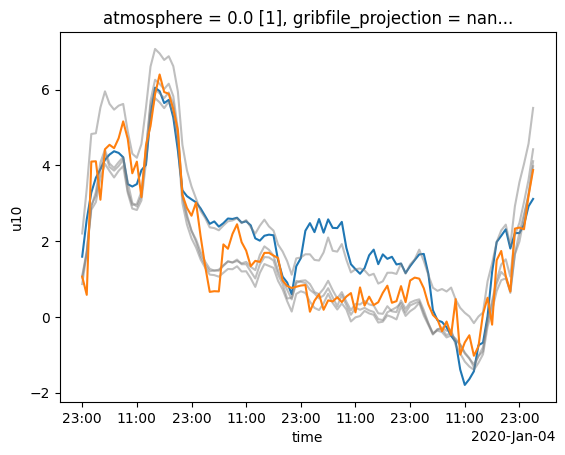

In [119]:
ds_in['10m_u_component_of_wind'].isel(x=50, y=60).plot()
for i in range(4):
    ds_out['u10'].isel(ensemble=i, x=50, y=60).plot(color='gray', alpha=0.5)
ds_tar['u10'].isel(x=50, y=60).plot()

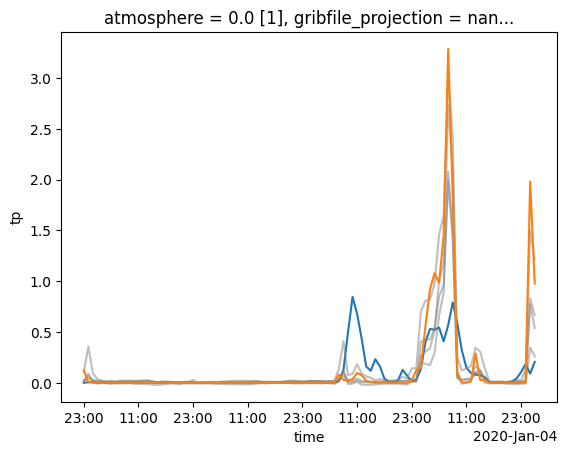

In [120]:
ds_in['total_precipitation'].isel(x=50, y=60).plot()
for i in range(4):
    ds_out['tp'].isel(ensemble=i, x=50, y=60).plot(color='gray', alpha=0.5)
ds_tar['tp'].isel(x=50, y=60).plot()

In [124]:
!pip install -q seaborn

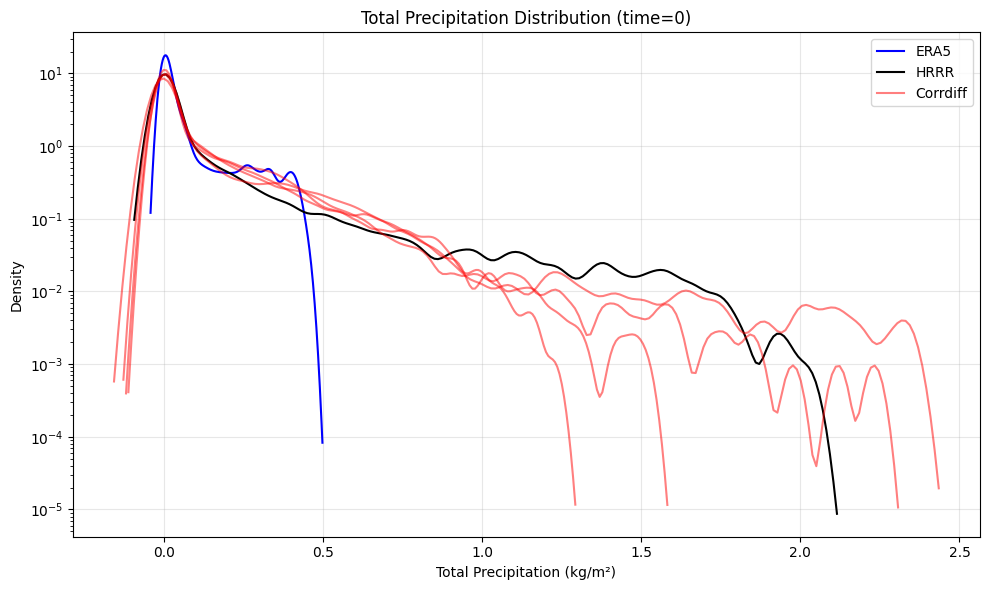

In [127]:
import seaborn as sns

id_t = 0  # Choose a time index

plt.figure(figsize=(10, 6))

# ERA5 input
sns.kdeplot(ds_in['total_precipitation'].isel(time=id_t).values.flatten(), 
            color='b', label='ERA5')

# HRRR target
sns.kdeplot(ds_tar['tp'].isel(time=id_t).values.flatten(), 
            color='k', label='HRRR')

# Corrdiff predictions (all ensembles)
for i in range(len(ds_out.ensemble)-1):
    sns.kdeplot(ds_out['tp'].isel(time=id_t, ensemble=i).values.flatten(), 
                color='r', alpha=0.5)
sns.kdeplot(ds_out['tp'].isel(time=id_t, ensemble=-1).values.flatten(), 
            color='r', alpha=0.5, label='Corrdiff')

plt.xlabel('Total Precipitation (kg/m²)')
plt.ylabel('Density')
plt.title(f'Total Precipitation Distribution (time={id_t})')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()

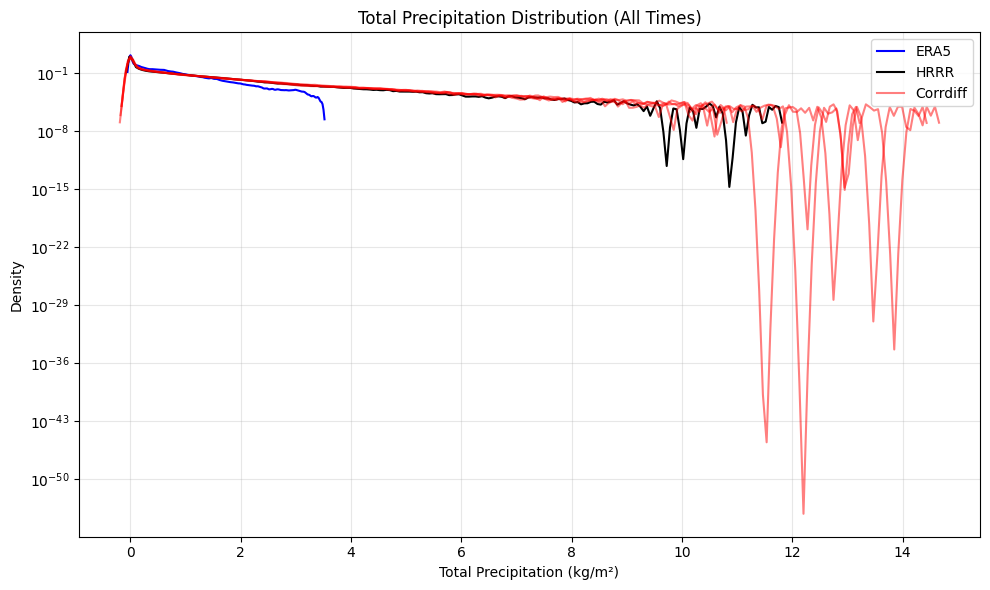

In [129]:
# Compare distributions across all times
plt.figure(figsize=(10, 6))

sns.kdeplot(ds_in['total_precipitation'].values.flatten(), 
            color='b', label='ERA5')
sns.kdeplot(ds_tar['tp'].values.flatten(), 
            color='k', label='HRRR')

for i in range(len(ds_out.ensemble)-1):
    sns.kdeplot(ds_out['tp'].isel(ensemble=i).values.flatten(), 
                color='r', alpha=0.5)
sns.kdeplot(ds_out['tp'].isel(ensemble=-1).values.flatten(), 
            color='r', alpha=0.5, label='Corrdiff')

plt.xlabel('Total Precipitation (kg/m²)')
plt.ylabel('Density')
plt.title('Total Precipitation Distribution (All Times)')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
#plt.xlim(0, 2)  # Adjust as needed
plt.tight_layout()

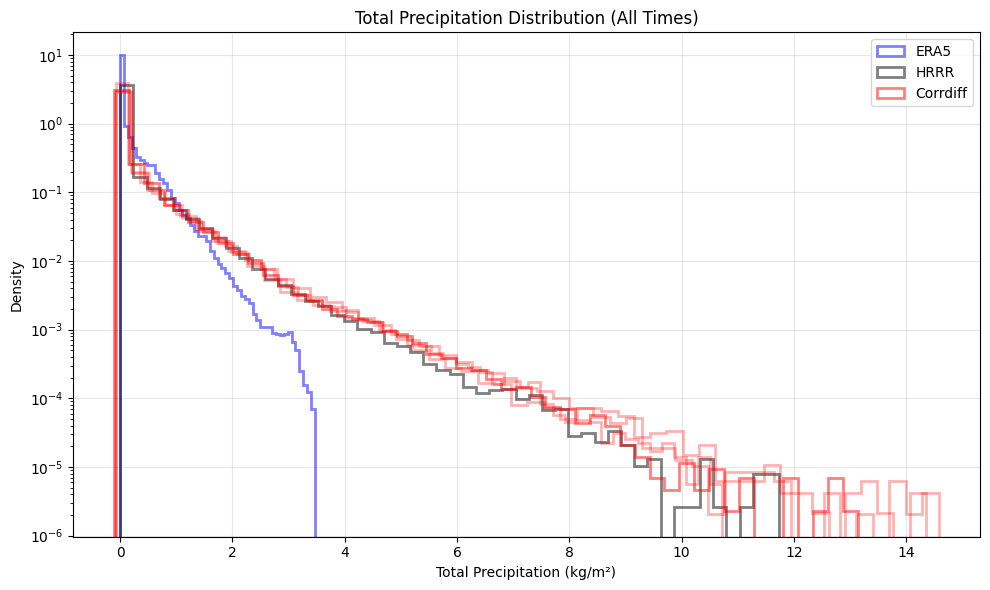

In [131]:
# Compare distributions across all times
plt.figure(figsize=(10, 6))

plt.hist(ds_in['total_precipitation'].values.flatten(), 
         bins=50, color='b', alpha=0.5, label='ERA5', density=True,histtype='step', linewidth=2)
plt.hist(ds_tar['tp'].values.flatten(), 
         bins=50, color='k', alpha=0.5, label='HRRR', density=True,histtype='step', linewidth=2)

for i in range(len(ds_out.ensemble)):
    alpha_val = 0.3 if i < len(ds_out.ensemble)-1 else 0.5
    label_val = 'Corrdiff' if i == len(ds_out.ensemble)-1 else None
    plt.hist(ds_out['tp'].isel(ensemble=i).values.flatten(), 
             bins=50, color='r', alpha=alpha_val, label=label_val, density=True,histtype='step', linewidth=2)

plt.xlabel('Total Precipitation (kg/m²)')
plt.ylabel('Density')
plt.title('Total Precipitation Distribution (All Times)')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
#plt.xlim(0, 2)  # Adjust as needed
plt.tight_layout()

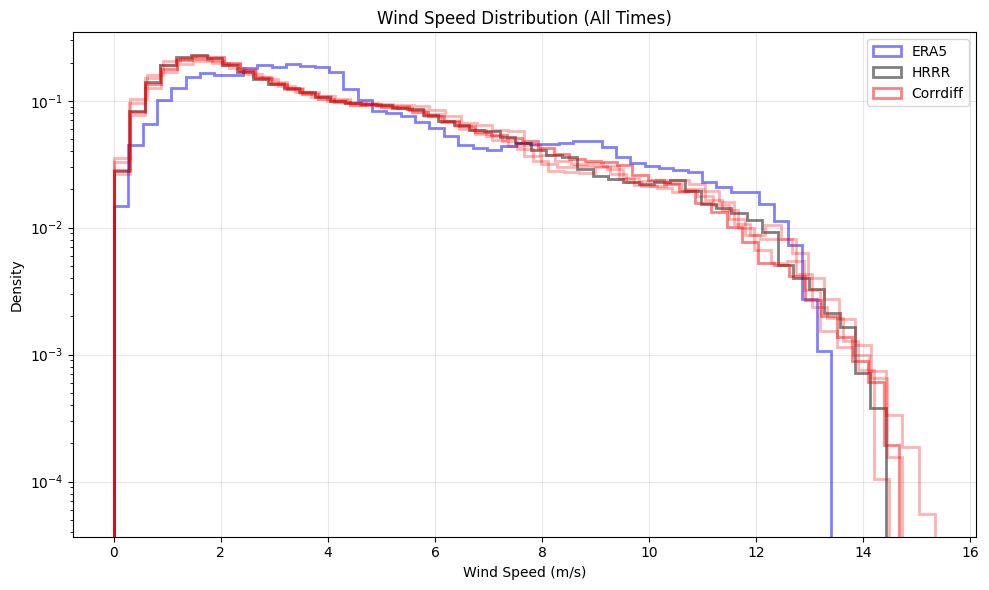

In [133]:
# Calculate wind speed magnitude
wind_speed_in = np.sqrt(ds_in['10m_u_component_of_wind'].values**2 + 
                        ds_in['10m_v_component_of_wind'].values**2)
wind_speed_tar = np.sqrt(ds_tar['u10'].values**2 + ds_tar['v10'].values**2)
wind_speed_out = np.sqrt(ds_out['u10'].values**2 + ds_out['v10'].values**2)

# Compare distributions across all times
plt.figure(figsize=(10, 6))

plt.hist(wind_speed_in.flatten(), 
         bins=50, color='b', alpha=0.5, label='ERA5', density=True, histtype='step', linewidth=2)
plt.hist(wind_speed_tar.flatten(), 
         bins=50, color='k', alpha=0.5, label='HRRR', density=True, histtype='step', linewidth=2)

for i in range(len(ds_out.ensemble)):
    alpha_val = 0.3 if i < len(ds_out.ensemble)-1 else 0.5
    label_val = 'Corrdiff' if i == len(ds_out.ensemble)-1 else None
    plt.hist(wind_speed_out[:, i, :, :].flatten(), 
             bins=50, color='r', alpha=alpha_val, label=label_val, density=True, 
             histtype='step', linewidth=2)

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Density')
plt.title('Wind Speed Distribution (All Times)')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()